In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = r"C:\Users\Rise Networks\Desktop\AI_theory_grader\educational_questions.json"
with open(file_path, "r") as f:
    json_data = json.load(f)

In [3]:
json_data[0]

{'question_id': '1',
 'type': 'theory',
 'answer': 'Photosynthesis is the process by which green plants make their food using sunlight, carbon dioxide, and water.',
 'correct': '<p>Photosynthesis is the process by which green plants make their food using sunlight, carbon dioxide, and water.</p>',
 'status': 'PENDING'}

In [4]:
# Filtering out the questions that are not theory
theory_questions = []
for data in json_data:
    if data["type"] == "theory":
        theory_questions.append(data)

In [5]:
len(theory_questions)

597

In [6]:
# Next action is to remove the <p> tag across the correct answers
for data in theory_questions:
    data["correct"] = data["correct"].strip("</p>")

In [7]:
theory_questions[0]

{'question_id': '1',
 'type': 'theory',
 'answer': 'Photosynthesis is the process by which green plants make their food using sunlight, carbon dioxide, and water.',
 'correct': 'Photosynthesis is the process by which green plants make their food using sunlight, carbon dioxide, and water.',
 'status': 'PENDING'}

In [8]:
# Load sentence transformers to vectorize or tokenize the correct answer and answer of the student
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

c:\Users\Rise Networks\Desktop\AI_theory_grader\aes_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
correct_answer = []
users_answer = []
for data in theory_questions:
    # Append the correct answer into the correct_answer list
    correct_answer.append(data["correct"])

    # Append the user answer into the users_answer list
    users_answer.append(data["answer"])

In [10]:
# Tokenizing the correct_answer and the users_answer
embeddings = []

# Creating a similarity list to store the similarity scores
similarity = []

# creating a counter to iterate through the number of reponses
count = 0
for correct, user in zip(correct_answer, users_answer):
    # Encoding the correct_answer and user's answer
    answer_embeddings = model.encode([correct, user])
    # Appending the embeddings of the correct_answer to the correct_answer_embeddings list
    embeddings.append(answer_embeddings)

# Check for the similarity using cosine similarity from sentence transformers and store inside similarity list
for source, compare in embeddings:
    similarity_score = util.pytorch_cos_sim(source, compare)
    similarity_score = round(float(similarity_score), 3)
    similarity.append(round(float(similarity_score), 3))

    # Append similarity score back to its id and combined response
    theory_questions[count]["similarity_score"] = similarity_score
    count += 1

In [11]:
# Creating X 
X = []
for i in embeddings:
    e = i.flatten()
    X.append(e)

In [12]:
# Convert X to array
X = np.array(X)
X.shape

(597, 768)

In [13]:
# Creating y
y = np.array(similarity)

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Attention, Dense, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError


# X.shape = (597, 768)
# y.shape = (597,)
X = np.array(X)
y = np.array(y)

# Reshape X to add "timesteps" dimension so Attention works
# Attention layer requires input shape: (batch_size, timesteps, features)
# We'll reshape to (597, 1, 768) – treating all features as a single timestep
X = X.reshape(-1, 1, X.shape[1])

# Define input layer
input_tensor = Input(shape=(1, 768))  # (timesteps=1, features=768)

# Apply self-attention
# Since timesteps=1, this is more like a passthrough — you might expand timesteps for full attention power
attention_output = Attention(use_scale=True)([input_tensor, input_tensor, input_tensor])

# Flatten and pass through dense layers
x = Flatten()(attention_output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(1)(x)  # Regression output

# Build and compile model
model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError(), MeanAbsoluteError()])

# Summary
model.summary()

# Fit model
history = model.fit(X, y, epochs=20, batch_size=32, validation_split=0.1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 768)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 768)    │          1 │ input_layer[0][0… │
│ (Attention)         │                   │            │ input_layer[0][0… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 768)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     98,432 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,754 (417.01 KB)

 Trainable params: 106,754 (417.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


c:\Users\Rise Networks\Desktop\AI_theory_grader\aes_venv\Lib\site-packages\keras\src\ops\nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.5747 - mean_absolute_error: 0.7086 - mean_squared_error: 0.5747 - val_loss: 0.0476 - val_mean_absolute_error: 0.2002 - val_mean_squared_error: 0.0476
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0381 - mean_absolute_error: 0.1760 - mean_squared_error: 0.0381 - val_loss: 0.0108 - val_mean_absolute_error: 0.0955 - val_mean_squared_error: 0.0108
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0092 - mean_absolute_error: 0.0727 - mean_squared_error: 0.0092 - val_loss: 0.0023 - val_mean_absolute_error: 0.0433 - val_mean_squared_error: 0.0023
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.0328 - mean_squared_error: 0.0031 - val_loss: 1.6781e-04 - val_mean_absolute_error: 0.0119 - val_mean_squared_error: 1.6781e-04
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4953e-04 - mean_absolute_error: 0.0123 - mean_squared_error: 9.4953e-04 - val_loss: 2.3962e-05 - v

In [15]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error
0,0.329906,0.483372,0.329906,0.047642,0.200174,0.047642
1,0.024372,0.131572,0.024372,0.010756,0.095460,0.010756
2,0.005306,0.053246,0.005306,0.002294,0.043256,0.002294
3,0.001802,0.023591,0.001802,0.000168,0.011897,0.000168
4,0.000985,0.011164,0.000985,0.000024,0.003998,0.000024


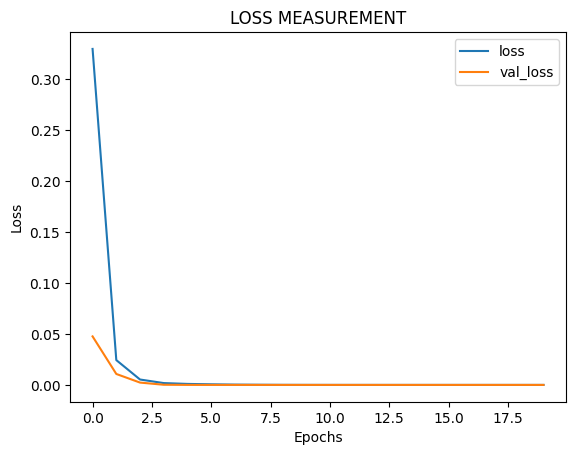

In [16]:
# Visualizing the loss of the model
history_df.loc[:, ["loss", "val_loss"]].plot()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LOSS MEASUREMENT");

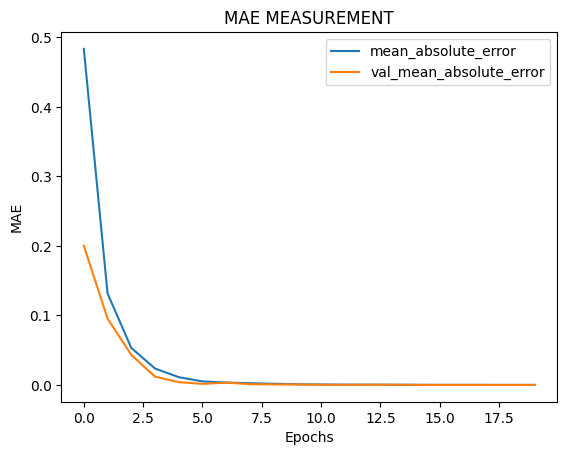

In [17]:
# Visualizing the loss of the model
history_df.loc[:, ["mean_absolute_error", "val_mean_absolute_error"]].plot()
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE MEASUREMENT");

In [18]:
loss, mae, mse = model.evaluate(X, y)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8960e-10 - mean_absolute_error: 1.3479e-05 - mean_squared_error: 4.8960e-10


In [19]:
print(f"The loss of the model: {loss}")
print(f"The mae of the model: {mae}")
print(f"The mse of the model: {mse}")

The loss of the model: 3.6517752710629736e-10
The mae of the model: 3.6517752710629736e-10
The mse of the model: 1.1981432180618867e-05


In [20]:
# Saving the model using pickle or tf
import pickle as pkl

with open("aes_grader.pkl", "wb") as f:
    pkl.dump(model, f)

In [2]:
# Now let's make predictions using the model
import pickle as pkl

with open("aes_grader.pkl", "rb") as f:
    aes_grader = pkl.load(f)

In [3]:
# Load the original data that was recieved from the backend
with open(r"C:\Users\Rise Networks\Desktop\AI_theory_grader\answer.json", "r") as f:
    original_json_data = json.load(f)

In [4]:
original_json_data

[{'question_id': '5',
  'type': 'theory',
  'answer': 'Science is the art of life',
  'correct': '<p>Science can be define as the art of life</p>',
  'status': 'PENDING'},
 {'question_id': '14',
  'type': 'multiple',
  'answer': '5',
  'correct': '5',
  'status': 'YES'},
 {'question_id': '15',
  'type': 'multiple',
  'answer': '2/3',
  'correct': '2/3',
  'status': 'YES'},
 {'question_id': '16',
  'type': 'multiple',
  'answer': '5',
  'correct': '5',
  'status': 'YES'},
 {'question_id': '17',
  'type': 'alternate',
  'answer': 'True',
  'correct': 'True',
  'status': 'YES'},
 {'question_id': '18',
  'type': 'theory',
  'answer': 'change the position of 4 over to right by subtracting both side by 4, = 12\r\ndivide both side by 3 , which is 12/3 = 4',
  'correct': '<p>Subtract 4 from both sides: 3x = 12. Divide by 3: x = 4.</p>',
  'status': 'PENDING'}]

In [6]:
# !pip install python-dotenv

In [2]:
import os
import requests

API_URL = "https://router.huggingface.co/hf-inference/models/facebook/bart-base/pipeline/feature-extraction"
headers = {
    "Authorization": f"Bearer {os.getenv('HF_TOKEN')}",
}

def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

output = query({
    "inputs": "Photosynthesis happens in plants using sunlight"
})

In [5]:
np.array(output).shape

(9, 768)

In [20]:
384*2

768

In [53]:
# Using huggingface_hub api for easier accessibility
import os
from huggingface_hub import InferenceClient
from dotenv import load_dotenv

load_dotenv()
# os.getenv("HF_TOKEN")
# sentence-transformers/all-mpnet-base-v2

client = InferenceClient(api_key=os.getenv("HF_TOKEN"), model="facebook/bart-base")

In [11]:
for data in original_json_data:
    if data["type"] == "theory":
        # answer_embed = client.sentence_similarity(data["answer"], data["correct"])
        source_embedding  = np.mean(client.feature_extraction(data["correct"]), axis=0)
        compare_embedding = np.mean(client.feature_extraction(data["answer"]), axis=0)

        # creating input vector uisng absolute difference
        input_vector = np.abs(source_embedding - compare_embedding).reshape(1, 1, 768)

        print(input_vector.shape)

        # Extracting the score 
        score = aes_grader.predict(input_vector)

        # Applying conditional formatting
        if score >= 0.5:
            data["PASSED"] = True
        else:
            data["PASSED"] = False

(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
(1, 1, 768)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [6]:
answer_a = "Photosynthesis happens in plants using sunlight"
answer_b = "Using sunlight, plants perform photosynthesis"

In [60]:
xx = np.mean(client.feature_extraction(answer_a), axis = 0)


In [61]:
yy = np.mean(client.feature_extraction(answer_b), axis = 0)

In [64]:
np.abs(xx - yy).reshape(1,1,768).shape

(1, 1, 768)

In [54]:
np.array(client.feature_extraction(answer_b)).shape

(9, 768)

In [55]:
np.array(client.feature_extraction(answer_a)).shape

(9, 768)

In [6]:
original_json_data

NameError: name 'original_json_data' is not defined